In [393]:
import warnings
warnings.filterwarnings('ignore')

In [395]:
import pandas as pd
import openpyxl

def process_excel(file_path):
    wb = openpyxl.load_workbook(file_path)
    sheet = wb.active 

    data = []
    current_crime_type = None
    encountered_crime_type = False 

    for row in range(8, sheet.max_row + 1): 
        cell_a_value = sheet.cell(row=row, column=1).value
        
        # Detect if the row represents a crime type.
        if not encountered_crime_type or (cell_a_value != None and sheet.cell(row=row, column=2).value == None):
            current_crime_type = cell_a_value
            encountered_crime_type = True 
            continue  
        
        # After a crime type, the next rows are age groups until the next crime type.
        # Check for actual data row (avoid empty or non-data rows).
        if cell_a_value and encountered_crime_type:
            age = cell_a_value  
            for col in range(2, sheet.max_column + 1):  
                year = sheet.cell(row=7, column=col).value 
                value = sheet.cell(row=row, column=col).value
                if value != None: 
                    data.append([current_crime_type, age, year, value])
            continue
        
        # Reset the flag if this row is empty and we're between crime types
        if cell_a_value == None:
            encountered_crime_type = False

    # Convert the collected data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['Type of Crime', 'Age', 'Year', 'Value'])
    return df
# Path to the Excel file you've uploaded
file_path = r'C:\Users\mahes\Downloads\age.xlsx'

# Process the Excel file 
df = process_excel(file_path)
df.columns = df.columns.str.replace(' ', '_', regex=False)
df['Type_of_Crime'] = df['Type_of_Crime'].apply(lambda x: ' '.join(x.split(' ')[1:]))
df['Age'] = df['Age'].str.strip()

df['Type_of_Crime'] = df['Type_of_Crime'].str.strip()
df = df[df['Type_of_Crime'] != 'Delitos']
df_filtered = df[df['Age'] != 'Total']

df_original = df_filtered

In [396]:
file_path = r'C:\Users\mahes\Downloads\age_exp.xlsx'
df_filtered.to_excel(file_path, index=False, engine='openpyxl')

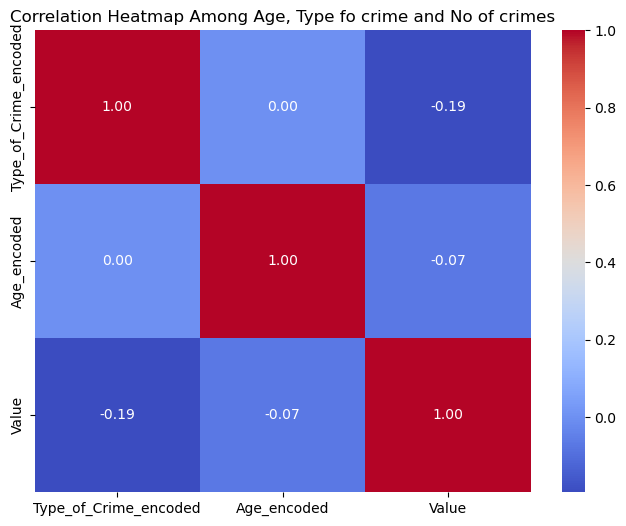

In [397]:
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding 'Type_of_Crime' and 'Age'
df_filtered['Type_of_Crime_encoded'] = df_filtered['Type_of_Crime'].astype('category').cat.codes
df_filtered['Age_encoded'] = df_filtered['Age'].astype('category').cat.codes

# Calculate correlations among encoded variables and 'Value'
corr = df_filtered[['Type_of_Crime_encoded', 'Age_encoded', 'Value']].corr()

# Plotting heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Among Age, Type fo crime and No of crimes')
plt.show()

In [ ]:
#From the heatmap , we could see very less correlation between age and type of crime and the correlation is negative

In [398]:

df_summary = df_filtered.groupby('Year')['Value'].sum().reset_index()
df_summary['Year'] = pd.to_datetime(df_summary['Year'].astype(str) + '-12-31')
df_summary.set_index('Year', inplace=True)

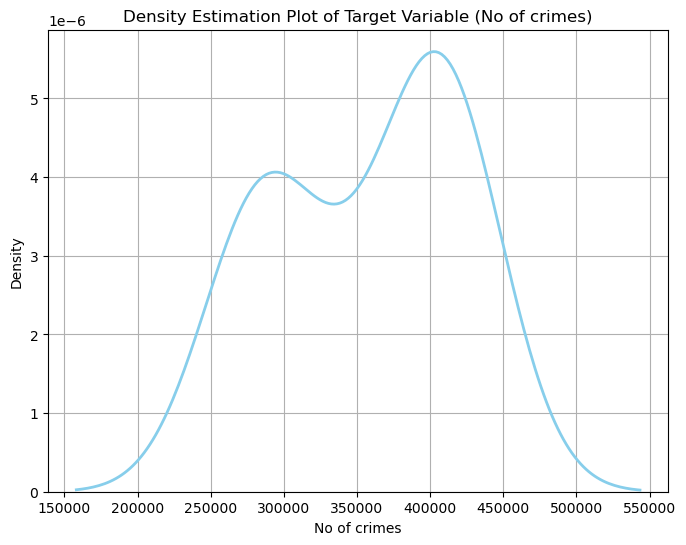

In [399]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.kdeplot(df_summary['Value'], color='skyblue', linewidth=2)
plt.title('Density Estimation Plot of Target Variable (No of crimes)')
plt.xlabel('No of crimes')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#analysis is that the value is not balanced as there is right skewed

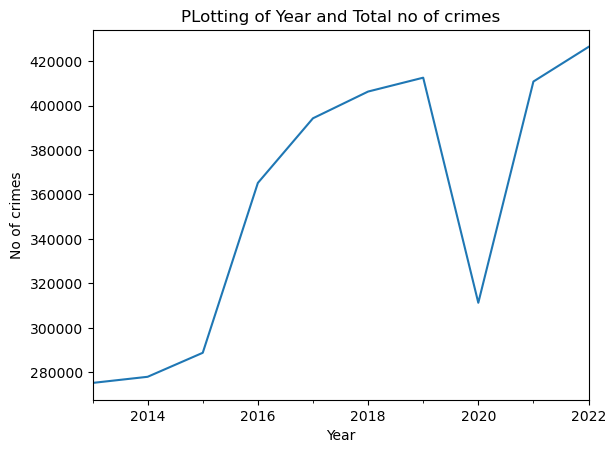

In [444]:
df_summary['Value'].plot(title='PLotting of Year and Total no of crimes')
plt.ylabel('No of crimes')
plt.show()

#The drop in crimes in 2020 can be due to corona

In [ ]:
#Forecast for the total no of crimes

In [401]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

result = adfuller(df_summary['Value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the p-value
if result[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

ADF Statistic: -1.531571
p-value: 0.517840
Series is not stationary


In [402]:
#Considering order of 2 ,2, 1 for order for simplicity

model = ARIMA(df_summary['Value'], order=(1,2,2))
model_fit = model.fit()
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   10
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -101.037
Date:                Sun, 17 Mar 2024   AIC                            210.074
Time:                        07:09:10   BIC                            210.392
Sample:                    12-31-2013   HQIC                           207.931
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4506      5.260     -0.086      0.932     -10.760       9.858
ma.L1         -0.1639      5.022     -0.033      0.974     -10.008       9.680
ma.L2         -0.4180      3.124     -0.134      0.8

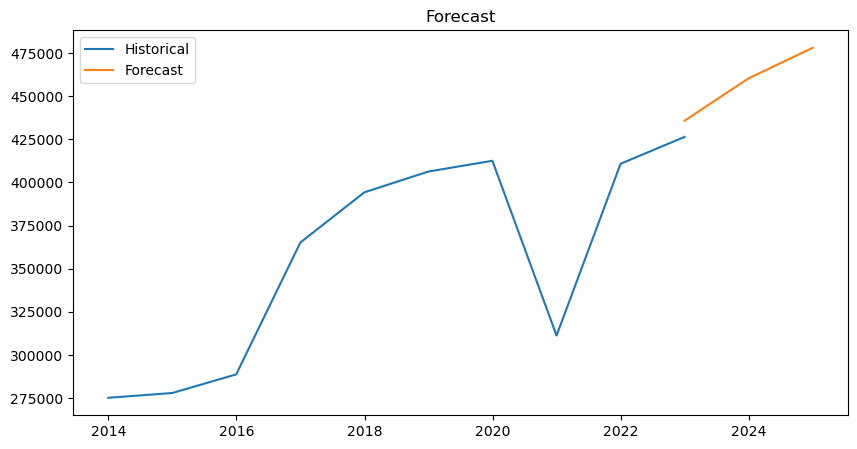

In [403]:
# Forecast the next 2 years
forecast_dates = pd.date_range(df_summary.index[-1], periods=3, freq='A')
forecast = model_fit.forecast(steps=len(forecast_dates))

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(df_summary.index, df_summary['Value'], label='Historical')
plt.plot(forecast_dates, forecast, label='Forecast')  
plt.title('Forecast')
plt.legend()
plt.show()

In [404]:
# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast
})

print(forecast_df)

                 Date       Forecast
2023-12-31 2022-12-31  435810.671581
2024-12-31 2023-12-31  460354.727734
2025-12-31 2024-12-31  478072.704954


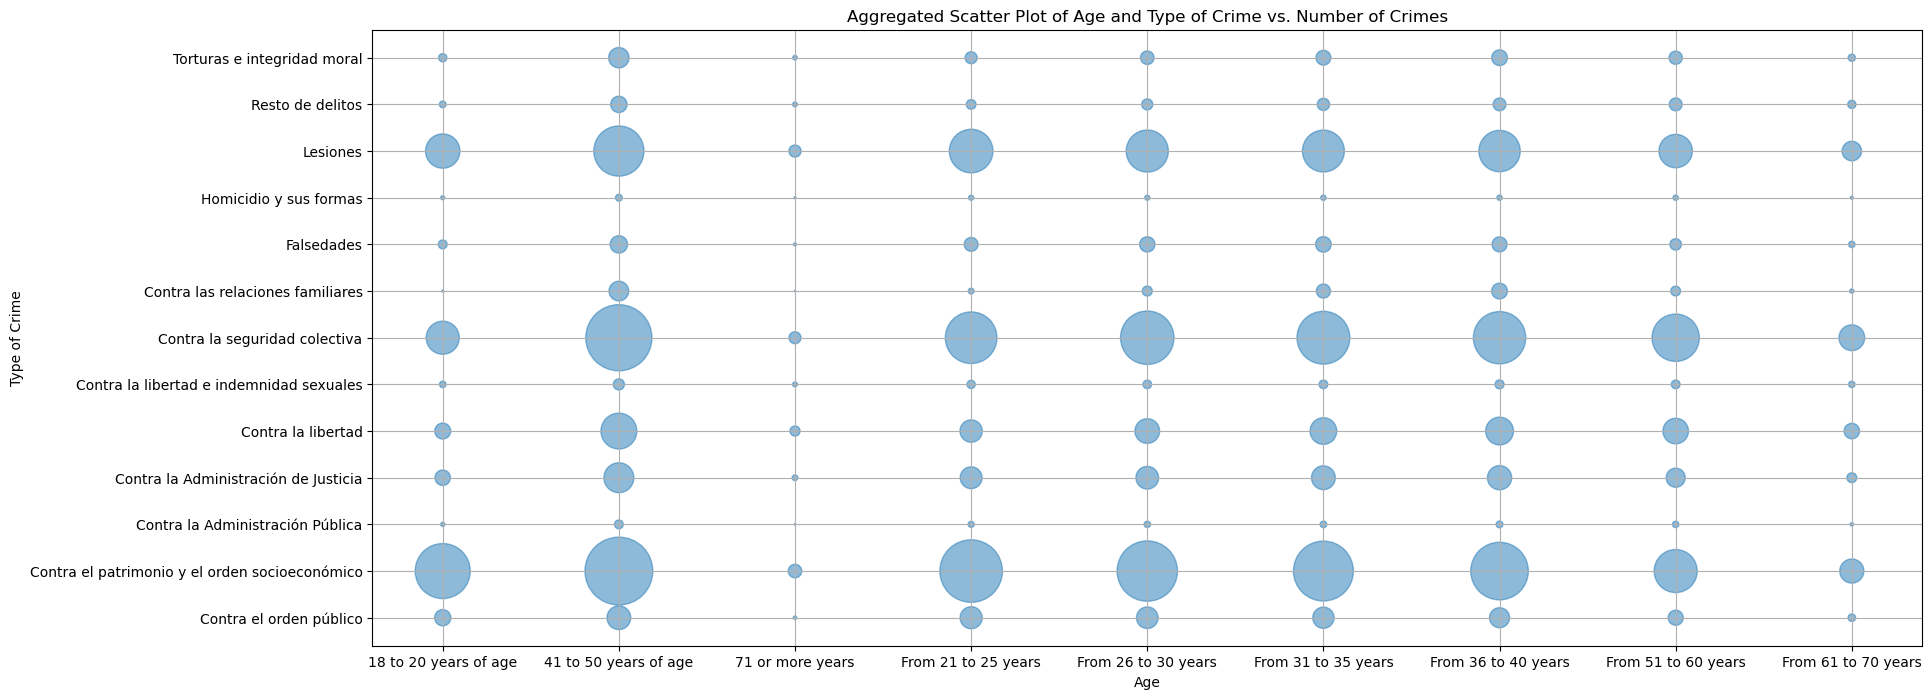

In [457]:
# Aggregate data
agg_df = df_filtered.groupby(['Age', 'Type_of_Crime']).agg({'Value': 'mean'}).reset_index()

# Assuming 'agg_df' is the aggregated DataFrame
plt.figure(figsize=(20, 8))
plt.scatter(agg_df['Age'], agg_df['Type_of_Crime'], s=agg_df['Value']  * 0.1, alpha=0.5)
plt.title('Aggregated Scatter Plot of Age and Type of Crime vs. Number of Crimes')
plt.xlabel('Age')
plt.ylabel('Type of Crime')
plt.grid(True)
plt.show()

#Prediction of no of crimes considering age and type of crime as regressor

In [377]:
#First using Prophet

In [405]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import joblib  # for saving the encoder model

# Initialize the encoders
type_of_crime_encoder = LabelEncoder()
age_encoder = LabelEncoder()

# Assuming your DataFrame 'df' has 'type_of_crime' and 'age' columns
df_filtered['type_of_crime_encoded'] = type_of_crime_encoder.fit_transform(df_filtered['Type_of_Crime'])
df_filtered['age_encoded'] = age_encoder.fit_transform(df_filtered['Age'])

In [ ]:
#!pip install prophet

In [406]:
# Save the encoders for future use
joblib.dump(type_of_crime_encoder, 'type_of_crime_encoder.joblib')
joblib.dump(age_encoder, 'age_encoder.joblib')

['age_encoder.joblib']

In [407]:
from prophet import Prophet
import pandas as pd

# Prepare your DataFrame for Prophet
df_filtered['ds'] = pd.to_datetime(df_filtered['Year'].astype(str) + '-12-31')
df_filtered['y'] = df_filtered['Value']

In [413]:
# Initialize and fit the Prophet model with additional regressors
model = Prophet(yearly_seasonality=False,changepoint_prior_scale=0.10)
model.add_regressor('age_encoded',  prior_scale=100)
model.add_regressor('type_of_crime_encoded', prior_scale=100)
model.fit(df_filtered, algorithm='LBFGS', iter=20000)

07:10:33 - cmdstanpy - INFO - Chain [1] start processing
07:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [414]:
#prediction paarmeters input


age_category = "From 31 to 35 years"
type_of_crime = "Homicidio y sus formas"
prediction_year = 2025

In [415]:
import matplotlib.pyplot as plt

# Load encoders
loaded_type_of_crime_encoder = joblib.load('type_of_crime_encoder.joblib')
loaded_age_encoder = joblib.load('age_encoder.joblib')

# Encode input parameters
input_age_encoded = loaded_age_encoder.transform([age_category])[0]
input_type_of_crime_encoded = loaded_type_of_crime_encoder.transform([type_of_crime])[0]

# Prepare future DataFrame for Prophet
last_known_year = df_filtered['ds'].dt.year.max()
future_years = list(range(last_known_year + 1, prediction_year + 1))
future_dates = pd.to_datetime([f"{year}-12-31" for year in future_years])
future_df = pd.DataFrame({'ds': future_dates})
future_df['age_encoded'] = input_age_encoded
future_df['type_of_crime_encoded'] = input_type_of_crime_encoded
forecast = model.predict(future_df[['ds', 'age_encoded', 'type_of_crime_encoded']])

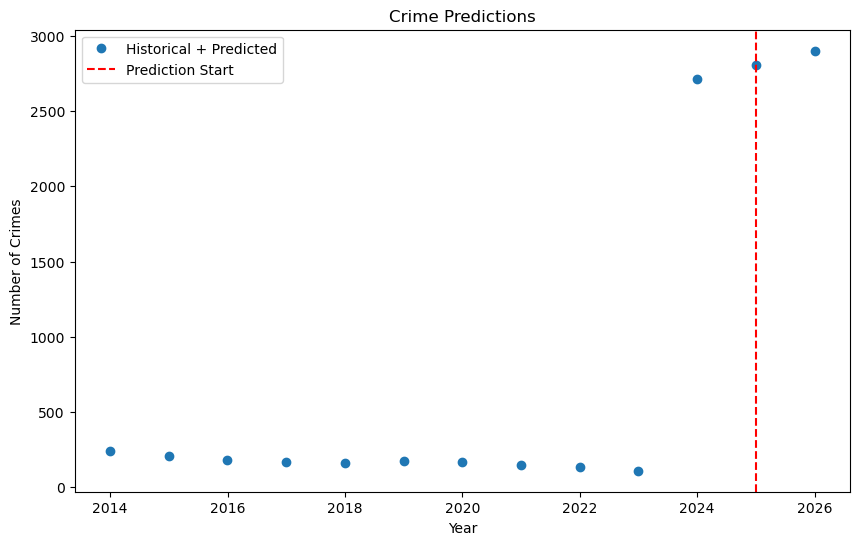

In [416]:
# Combine historical and forecast data for plotting
historical_data =  df_filtered[(df_filtered['age_encoded'] == input_age_encoded) & (df_filtered['type_of_crime_encoded'] == input_type_of_crime_encoded)]
forecast_data = forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'})
combined_data = pd.concat([historical_data, forecast_data])

# Plot
plt.figure(figsize=(10, 6))
plt.plot_date(combined_data['ds'], combined_data['y'], label='Historical + Predicted')
plt.axvline(x=pd.to_datetime('2025'), color='r', linestyle='--', label='Prediction Start')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crime Predictions')
plt.legend()
plt.show()

In [ ]:
!pip install lightgbm

##Prediction using Lightbgm considering three lags

In [417]:
df_filtered = df_filtered.sort_values(by=['age_encoded', 'type_of_crime_encoded', 'ds'])
df_filtered['y_lag1'] = df_filtered.groupby(['age_encoded', 'type_of_crime_encoded'])['y'].shift(1)
df_filtered['y_lag2'] = df_filtered.groupby(['age_encoded', 'type_of_crime_encoded'])['y'].shift(2)
df_filtered['y_lag3'] = df_filtered.groupby(['age_encoded', 'type_of_crime_encoded'])['y'].shift(3)
df_filtered.dropna(inplace=True)
df_filtered['y'] = df_filtered['y'].astype(float)

In [418]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


# Feature and target arrays
X = df_filtered[['age_encoded', 'type_of_crime_encoded', 'y_lag1', 'y_lag2', 'y_lag3']]  # Add more features as needed
y = df_filtered['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [419]:
# Initialize and train the LightGBM model
model = LGBMRegressor(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=1000
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l2')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 655, number of used features: 5
[LightGBM] [Info] Start training from score 3755.322137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(learning_rate=0.05, n_estimators=1000)

In [420]:
import numpy as np
# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse}')


Test RMSE: 836.2259079653106


In [426]:
#prediction paarmeters input
age_category = "From 31 to 35 years"
type_of_crime = "Contra la libertad"
prediction_year = 2025

In [459]:
# Encode input parameters
input_age_encoded = loaded_age_encoder.transform([age_category])[0]
input_type_of_crime_encoded = loaded_type_of_crime_encoder.transform([type_of_crime])[0]

# Filter df_filtered for the specific 'Age' and 'Type_of_Crime' to get the most recent 'y'
specific_filter = (df_filtered['type_of_crime_encoded'] == input_type_of_crime_encoded) & (df_filtered['age_encoded'] == input_age_encoded)
filtered_for_specific = df_filtered[specific_filter]

if filtered_for_specific.empty:
    print(f"No historical data found for Age: {age_category} and Type of Crime: {type_of_crime}.")
else:
    last_date = filtered_for_specific['ds'].max()
    last_year = last_date.year



In [460]:
filtered_for_specific = filtered_for_specific.sort_values('ds')
for year in range(last_year + 1, prediction_year ):
    # Check if there are at least three records to retrieve the second and third last 'y' values
    if len(filtered_for_specific) >= 3:
        most_recent_y = filtered_for_specific.iloc[-1]['y'] 
        most_recent_y1 = filtered_for_specific.iloc[-2]['y'] 
        most_recent_y2 = filtered_for_specific.iloc[-3]['y']  
    elif len(filtered_for_specific) == 2:
        most_recent_y = filtered_for_specific.iloc[-1]['y']
        most_recent_y1 = filtered_for_specific.iloc[-2]['y']
        most_recent_y2 = most_recent_y1  
    else:  
        most_recent_y = filtered_for_specific.iloc[-1]['y'] if len(filtered_for_specific) >= 1 else 0
        most_recent_y1 = most_recent_y
        most_recent_y2 = most_recent_y

    # Prepare DataFrame for prediction
    predict_df = pd.DataFrame({

        'age_encoded': [input_age_encoded],
        'type_of_crime_encoded': [input_type_of_crime_encoded],
        'y_lag1': [most_recent_y],
        'y_lag2': [most_recent_y1],
        'y_lag3': [most_recent_y2]
    })

    # Make the prediction
    predicted_y = model.predict(predict_df)[0]

    # Create a new entry for the prediction
    new_date = pd.Timestamp(year, 12, 31) 
    new_entry = {
        'y_lag1': [most_recent_y],
        'y_lag2': [most_recent_y1],
        'y_lag3': [most_recent_y2],
        'ds': new_date,
        'y': predicted_y,
        'age_encoded': input_age_encoded,
        'type_of_crime_encoded': input_type_of_crime_encoded
    }

    # Append the new entry to specific_data and df_filtered
    new_entry_df = pd.DataFrame([new_entry])
    filtered_for_specific = pd.concat([filtered_for_specific, new_entry_df], ignore_index=True)

    # Update last_date for the next iteration
    last_date = new_date

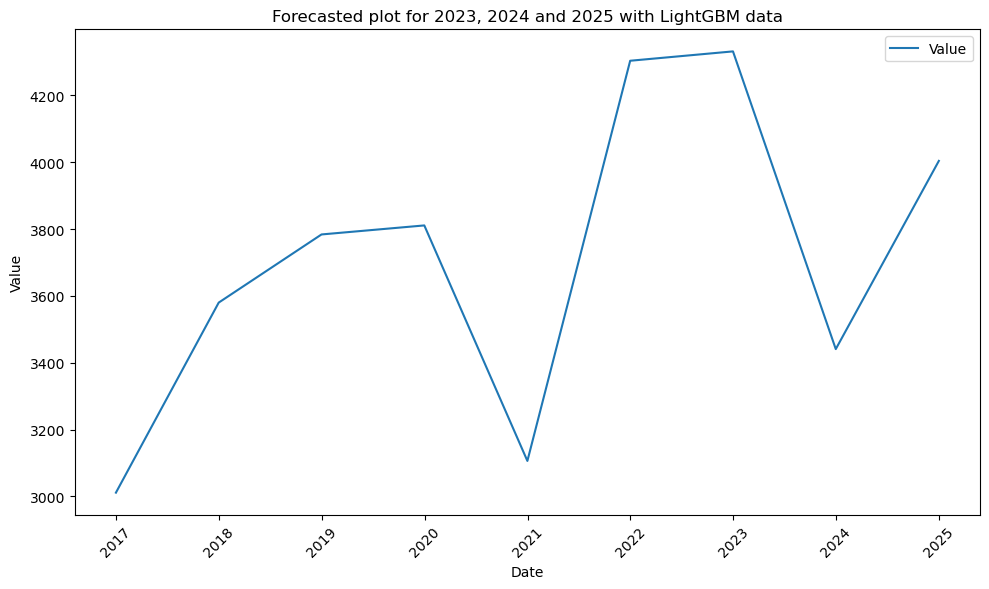

In [461]:
# Plotting
plt.figure(figsize=(10, 6)) 
plt.plot(filtered_for_specific['ds'], filtered_for_specific['y'], label='Value')  
plt.title('Forecasted plot for 2023, 2024 and 2025 with LightGBM data(uisng three lags)')  
plt.xlabel('Date') 
plt.ylabel('Value') 
plt.xticks(rotation=45)  
plt.legend()  
plt.tight_layout() 
plt.show()

#Preidction using linear regerssion model considering three lags

In [436]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
print("Linear Regression Root Mean Squared Error:", rmse_linear)

Linear Regression Root Mean Squared Error: 504.7308993838806


In [462]:
# Encode input parameters
input_age_encoded = loaded_age_encoder.transform([age_category])[0]
input_type_of_crime_encoded = loaded_type_of_crime_encoder.transform([type_of_crime])[0]

# Filter df_filtered for the specific 'Age' and 'Type_of_Crime'
specific_filter = (df_filtered['type_of_crime_encoded'] == input_type_of_crime_encoded) & (df_filtered['age_encoded'] == input_age_encoded)
filtered_for_specific = df_filtered[specific_filter]

if filtered_for_specific.empty:
    print(f"No historical data found for Age: {age_category} and Type of Crime: {type_of_crime}.")
else:
    last_date = filtered_for_specific['ds'].max()
    last_year = last_date.year

In [463]:
filtered_for_specific = filtered_for_specific.sort_values('ds')
for year in range(last_year + 1, prediction_year ):
    # Check if there are at least three records to retrieve the second and third last 'y' values
    if len(filtered_for_specific) >= 3:
        most_recent_y = filtered_for_specific.iloc[-1]['y'] 
        most_recent_y1 = filtered_for_specific.iloc[-2]['y'] 
        most_recent_y2 = filtered_for_specific.iloc[-3]['y'] 
    elif len(filtered_for_specific) == 2:
        most_recent_y = filtered_for_specific.iloc[-1]['y']
        most_recent_y1 = filtered_for_specific.iloc[-2]['y']
        most_recent_y2 = most_recent_y1  
    else:  
        most_recent_y = filtered_for_specific.iloc[-1]['y'] if len(filtered_for_specific) >= 1 else 0
        most_recent_y1 = most_recent_y
        most_recent_y2 = most_recent_y

    # Prepare DataFrame for prediction
    predict_df = pd.DataFrame({

        'age_encoded': [input_age_encoded],
        'type_of_crime_encoded': [input_type_of_crime_encoded],
        'y_lag1': [most_recent_y],
        'y_lag2': [most_recent_y1],
        'y_lag3': [most_recent_y2]
    })

    # Make the prediction
    predicted_y = linear_model.predict(predict_df)[0] 

    # Create a new entry for the prediction
    new_date = pd.Timestamp(year, 12, 31)  # Year-end timestamp
    new_entry = {
        'y_lag1': [most_recent_y],
        'y_lag2': [most_recent_y1],
        'y_lag3': [most_recent_y2],
        'ds': new_date,
        'y': predicted_y,
        'age_encoded': input_age_encoded,
        'type_of_crime_encoded': input_type_of_crime_encoded
    }

    # Append the new entry to specific_data and df_filtered
    new_entry_df = pd.DataFrame([new_entry])
    filtered_for_specific = pd.concat([filtered_for_specific, new_entry_df], ignore_index=True)

    # Update last_date for the next iteration
    last_date = new_date

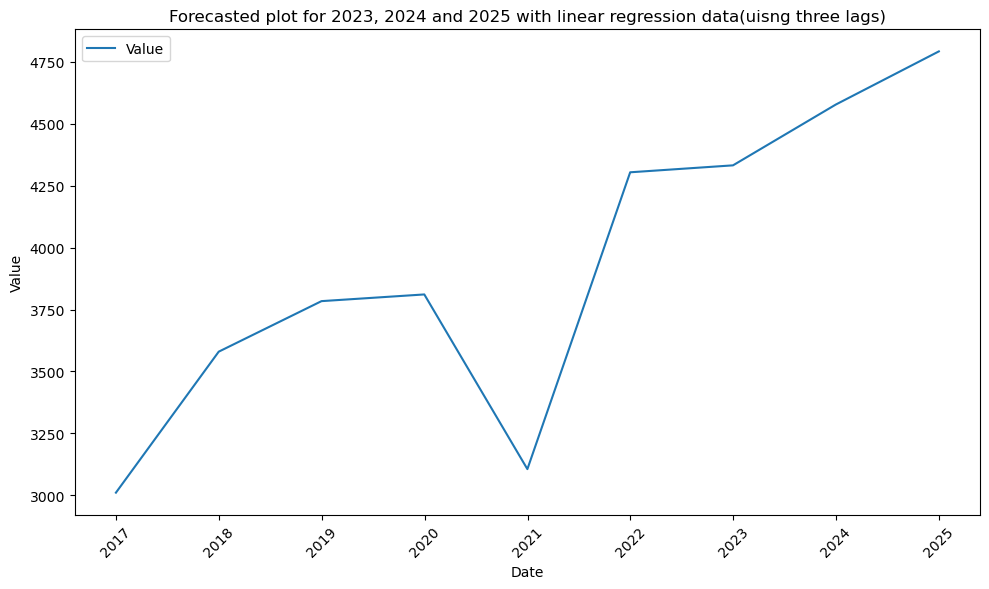

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))  
plt.plot(filtered_for_specific['ds'], filtered_for_specific['y'], label='Value')  # Plot 'y' against 'ds'
plt.title('Forecasted plot for 2023, 2024 and 2025 with linear regression data(using three lags)')  
plt.xlabel('Date')  
plt.ylabel('Value')  
plt.xticks(rotation=45)  
plt.legend() 
plt.tight_layout()  
plt.show()

In [467]:
df_filtered

,Type_of_Crime,Age,Year,Value,Type_of_Crime_encoded,Age_encoded,type_of_crime_encoded,age_encoded,ds,y,y_lag1,y_lag2,y_lag3
1216,Contra el orden público,18 to 20 years of age,2016,1239,0,0,0,0,2016-12-31,1239.0,1207.0,1171.0,1215.0
1215,Contra el orden público,18 to 20 years of age,2017,1287,0,0,0,0,2017-12-31,1287.0,1239.0,1207.0,1171.0
1214,Contra el orden público,18 to 20 years of age,2018,1214,0,0,0,0,2018-12-31,1214.0,1287.0,1239.0,1207.0
1213,Contra el orden público,18 to 20 years of age,2019,1368,0,0,0,0,2019-12-31,1368.0,1214.0,1287.0,1239.0
1212,Contra el orden público,18 to 20 years of age,2020,1145,0,0,0,0,2020-12-31,1145.0,1368.0,1214.0,1287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,Torturas e integridad moral,From 61 to 70 years,2018,260,12,8,12,8,2018-12-31,260.0,266.0,243.0,140.0
483,Torturas e integridad moral,From 61 to 70 years,2019,243,12,8,12,8,2019-12-31,243.0,260.0,266.0,243.0
482,Torturas e integridad moral,From 61 to 70 years,2020,221,12,8,12,8,2020-12-31,221.0,243.0,260.0,266.0
481,Torturas e integridad moral,From 61 to 70 years,2021,357,12,8,12,8,2021-12-31,357.0,221.0,243.0,260.0
